# Ancillary external photometry

This tutorial shows how to use external photometric data to perform astrometry calibrations on a Cube

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from pykoala.data_container import Cube

cube = Cube.from_fits("products/Henize_2-10_cube_no_sky.fits.gz",
                        hdul_extensions_map={"INTENSITY": "INTENSITY", "VARIANCE": "VARIANCE"})

# Read the sky position and cube pixel size from the header
he2_10_ra, he2_10_dec = cube.wcs.celestial.wcs.crval[:2]
cube_pix_area = (cube.wcs.celestial.wcs.cdelt[0] * 3600)**2
print(f"Cube position: RA={he2_10_ra}, DEC={he2_10_dec}")
print("Cube pixel area (arcsec^2) ", cube_pix_area)

[pykoala.pykoala.cube] 2024/09/15 16:51|INFO> WARNING: No `wavelength` vector supplied; creating empty `SpectraContainer`
[pykoala.pykoala.cube] 2024/09/15 16:51|INFO> [Cube] Looking for information in the primary header
[pykoala.pykoala.cube] 2024/09/15 16:51|INFO> [Cube] Constructing wavelength array
Cube position: RA=129.06270331214, DEC=-26.412717838961
Cube pixel area (arcsec^2)  1.000000000000016


In [3]:
from pykoala.photometry import query_image

# Query r-band photometry from PS using a cutout with the size of the input cube
# + 30 additional arcseconds on every side. Save the fits in the current working directory
image_query_results = query_image([cube], filters='i', im_extra_size_arcsec=30, im_output_dir='.')

[pykoala] 2024/09/15 16:51|INFO> Querying image to external database
[pykoala] 2024/09/15 16:51|INFO> Combined footprint Fov: 0.7258105450495123, 0.9833341037292342
[pykoala] 2024/09/15 16:51|INFO> Image center sky position (RA, DEC): (129.06285839986214, -26.412578822823143)
[pykoala] 2024/09/15 16:51|INFO> Image size (pixels): 356
projcell subcell         ra                 dec         filter mjd  type                                filename                                                 shortname                  badflag                                                                                              url                                                                                             
-------- ------- ------------------ ------------------- ------ --- ----- ---------------------------------------------------------------------- ------------------------------------------- ------- -----------------------------------------------------------------------------------

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [5]:
from pykoala.corrections.astrometry import AstrometryOffsetCorrection

astrometric_correction, results = AstrometryOffsetCorrection.from_external_image(
    cube, image_query_results["PS1.i"], filter_name="PANSTARRS_PS1.i")


/home/pcorchoc/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[pykoala] 2024/09/15 16:52|INFO> Computing aperture fluxes using Cube syntheticphotometry
[pykoala] 2024/09/15 16:52|INFO> Creating a grid of circular aperture (rad=0.62 px) every 2.5 pixels
[pykoala] 2024/09/15 16:52|INFO> Total number of apertures: 425


/home/pcorchoc/Develop/koala/src/pykoala/photometry.py:487: RuntimeWarning: divide by zero encountered in log10
  mappable = ax.imshow(-2.5 * np.log10(synth_phot / 3631), vmin=16, vmax=23,
/home/pcorchoc/Develop/koala/src/pykoala/photometry.py:487: RuntimeWarning: invalid value encountered in log10
  mappable = ax.imshow(-2.5 * np.log10(synth_phot / 3631), vmin=16, vmax=23,
/home/pcorchoc/Develop/koala/src/pykoala/photometry.py:491: RuntimeWarning: divide by zero encountered in divide
  mappable = ax.imshow(synth_phot / synth_phot_err, vmin=0, vmax=10, cmap='jet',
/home/pcorchoc/Develop/koala/src/pykoala/photometry.py:491: RuntimeWarning: invalid value encountered in divide
  mappable = ax.imshow(synth_phot / synth_phot_err, vmin=0, vmax=10, cmap='jet',


[pykoala] 2024/09/15 16:52|INFO> Computing astrometric offsets
[pykoala] 2024/09/15 16:52|INFO> Cross-correlating image to list of apertures
[pykoala] 2024/09/15 16:52|INFO> Input number of apertures: 147


/home/pcorchoc/Develop/koala/src/pykoala/photometry.py:497: RuntimeWarning: divide by zero encountered in log10
  c= -2.5 * np.log10(ap_flux / 3631), vmin=16, vmax=23)
/home/pcorchoc/Develop/koala/src/pykoala/photometry.py:497: RuntimeWarning: invalid value encountered in log10
  c= -2.5 * np.log10(ap_flux / 3631), vmin=16, vmax=23)
/home/pcorchoc/Develop/koala/src/pykoala/photometry.py:502: RuntimeWarning: divide by zero encountered in divide
  c= ap_flux /ap_flux_err, vmin=0, vmax=10)
/home/pcorchoc/Develop/koala/src/pykoala/photometry.py:502: RuntimeWarning: invalid value encountered in divide
  c= ap_flux /ap_flux_err, vmin=0, vmax=10)


[pykoala] 2024/09/15 16:52|INFO> Computing the offset solution


/home/pcorchoc/Develop/koala/src/pykoala/photometry.py:761: RuntimeWarning: divide by zero encountered in log10
  synt_sb = -2.5 * np.log10(ref_image / 3631)
/home/pcorchoc/Develop/koala/src/pykoala/photometry.py:761: RuntimeWarning: invalid value encountered in log10
  synt_sb = -2.5 * np.log10(ref_image / 3631)
/home/pcorchoc/Develop/koala/src/pykoala/photometry.py:762: RuntimeWarning: invalid value encountered in log10
  im_sb = -2.5 * np.log10(image['intensity'] / 3631 / image['pix_size']**2)


In [ ]:
results["fig"]

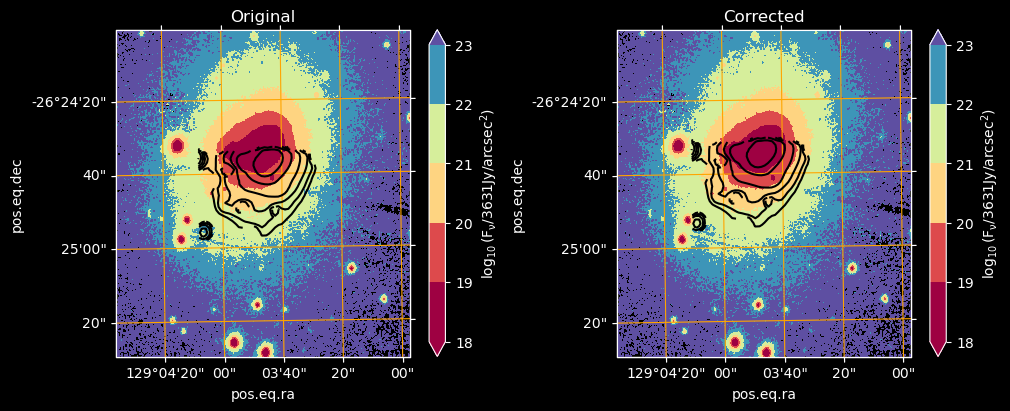

In [7]:
results["offset_fig"]

In [6]:
cube = astrometric_correction.apply(cube)
# Save the final version of the cube
cube.to_fits("products/Henize_2-10_cube_astrometry.fits.gz")

[pykoala.correction.AstrometryOffsetCorrection] 2024/09/15 16:52|INFO> Applying astrometry offset correction to DC (RA, DEC): [3.05964782 2.32178741]
[pykoala.pykoala.cube] 2024/09/15 16:52|INFO> Previous CRVAL: [129.06270331 -26.41271784]
New CRVAL: [129.06355321 -26.4120729 ]
